Preparation

In [24]:
# Download a Pretrained Model because training takes a long time
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/normal.pt

# Download a Pretrained Model Trained on Augmented Data because training takes a long time
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/rotated_data.pt

--2022-12-13 13:56:04--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/normal.pt
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75134 (73K) [application/octet-stream]
Saving to: ‘normal.pt.1’

normal.pt.1         100%[===================>]  73.37K  --.-KB/s    in 0.002s  

2022-12-13 13:56:04 (35.6 MB/s) - ‘normal.pt.1’ saved [75134/75134]

--2022-12-13 13:56:04--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/rotated_data.pt
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlay

In [25]:
# library to show images
!pip install Pillow==6.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


restart the kernel

In [26]:
# Import the libraries we need to use in this lab
# Using the following line code to install the torchvision library
# !conda install -y torchvision

# PyTorch Library
import torch 
# PyTorch Neural Network Library
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Used to graph data and loss curves
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np
# Allows us to download the dataset
import torchvision.datasets as dsets
# Allows us to access the filesystem
import os  

In [27]:
def plot_cost_accuracy(checkpoint):

# Plot the cost and accuracy

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(checkpoint['cost'], color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color) 
    ax2.set_xlabel('epoch', color=color)
    ax2.plot( checkpoint['accuracy'], color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

In [28]:
def show_data(data_sample):
  plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
  plt.title('y='+str(data_sample[1]))

In [29]:
def plot_mis_classified(model,dataset):
  count=0
  for x,y in torch.utils.data.DataLoader(dataset=dataset,batch_size = 1):
    z = model(x)
    _, yhat = torch.max(z,1)
    if yhat != y:
      show_data((x,y))
      plt.show()
      count += 1
    if count>= 5:
      break

Load Data

In [30]:
# size of the images are 16 by 16
IMAGE_SIZE = 16

# creating a group of transformations to created a rotated dataset
# resizes the images, ramdomly rotates it, and then converts it to a tensor
compose_rotate = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),transforms.RandomAffine(45),transforms.ToTensor()])

# creating a group of transformations to created a non rotated dataset
# resizes the images then converts it to a tensor
compose = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),transforms.ToTensor()])

In [31]:
# The transform parameters is set to the corresponding compose
train_dataset_rotate = dsets.MNIST(root='./data', train=True, download=True, transform=compose_rotate)
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=compose)

In [32]:
#Load the testing dataset
validation_dataset = dsets.MNIST(root='./data',train=False,download=True,transform=compose_rotate)

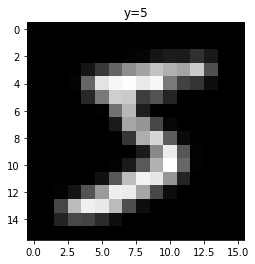

In [33]:
show_data(train_dataset[0])

In [34]:
train_dataset[0][1]

5

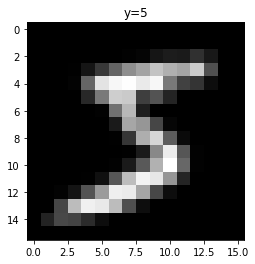

In [35]:
show_data(train_dataset_rotate[0])

Build a convolutional neural network class

In [36]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        
        # The reason we start with 1 channel is because we have a single black and white image
        # Channel Width after this layer is 16
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        # Channel Wifth after this layer is 8
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        # Channel Width after this layer is 8
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        # Channel Width after this layer is 4
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        # In total we have out_2 (32) channels which are each 4 * 4 in size based on the width calculation above. Channels are squares.
        # The output is a value for each class
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        # Puts the X value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    # Outputs result of each stage of the CNN, relu, and pooling layers
    def activations(self, x):
        # Outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out


Regular data

In [37]:
model = CNN(out_1=16,out_2=32)

In [38]:
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# Create a Data Loader for the training data with a batch size of 100 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
# Create a Data Loader for the rotated validation data with a batch size of 5000 
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [39]:
#analyze results
checkpoint_normal = torch.load(os.path.join(os.getcwd(),'normal.pt'))

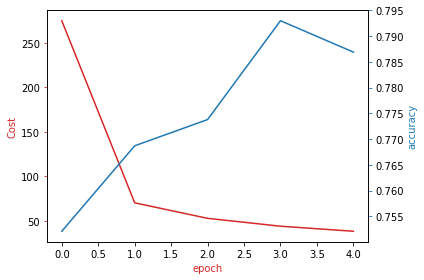

In [40]:
# Plot Accuracy and Cost vs Epoch Graph

# using the helper function degined at the top and the cost and accuracy lists that saved
plot_cost_accuracy(checkpoint_normal)

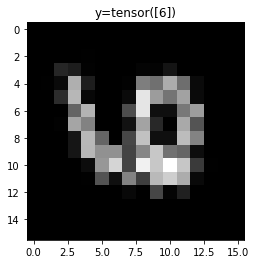

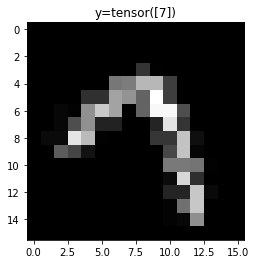

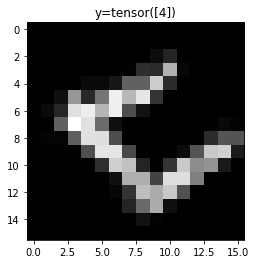

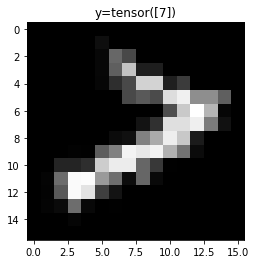

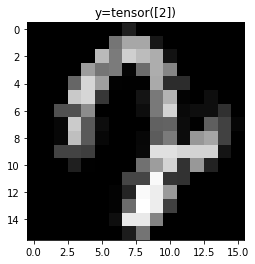

In [41]:
# Five misclassified samples

# using the model parameters we saved we load them into a model to recreate the trained model
model.load_state_dict(checkpoint_normal['model_state_dict'])
# setting the model to evaluation mode
model.eval()
# using the helper function plot the first five misclassified samples
plot_mis_classified(model,validation_dataset)

Rotated training data

In [42]:
# create the model object using CNN class
model_r = CNN(out_1=16,out_2=32)
criterion = nn.CrossEntropyLoss()
learning_rate=0.1
optimizer=torch.optim.SGD(model_r.parameters(),lr=learning_rate)
train_loader =torch.utils.data.DataLoader(dataset=train_dataset_rotate,batch_size=100)
validation_loader =torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=5000)

In [43]:
#analyze results
checkpoint_rotated = torch.load(os.path.join(os.getcwd(),'rotated_data.pt'))

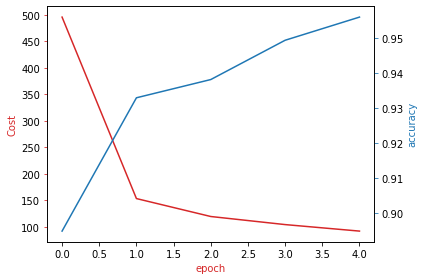

In [44]:
# Plot Accuracy and Cost vs Epoch Graph

# using the helper function degined at the top and the cost and accuracy lists that saved
plot_cost_accuracy(checkpoint_rotated)

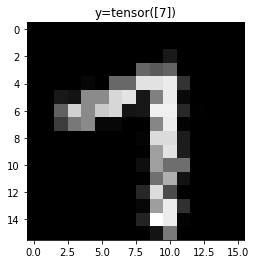

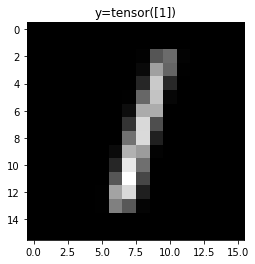

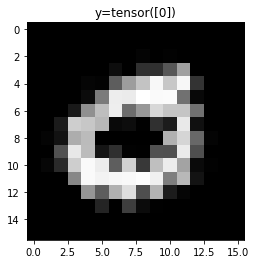

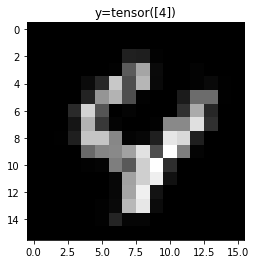

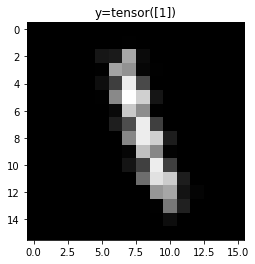

In [45]:
# Five misclassified samples

# using the model parameters we saved we load them into a model to recreate the trained model
model.load_state_dict(checkpoint_rotated['model_state_dict'])
# setting the model to evaluation mode
model.eval()
# using the helper function plot the first five misclassified samples
plot_mis_classified(model_r,validation_dataset)